# Silver Price Analysis & Forecasting (2016–2026)

**Author:** *Hammad zahid*  
**Role:** Data Scientist & Market Analyst  
**Data Source:** Yahoo Finance (via `yfinance` – pre-downloaded as CSV)  
**Ticker:** `SI=F` (COMEX Silver Futures)  

---

## 1. Project Overview

This notebook performs a **full end-to-end analysis** and **forecasting** of COMEX Silver Futures prices from **Jan 2016 to Jan 2026**, using:

- **Python stack:** `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, `Prophet`, `statsmodels`
- **Methods:**
  - Exploratory Data Analysis (EDA)
  - Time Series Analysis (trend, seasonality, stationarity tests)
  - Feature Engineering (returns, volatility, technical indicators, calendar features)
  - Machine Learning Forecasting (Tree-based model)
  - Probabilistic Time Series Forecasting (Prophet)
  - Model Evaluation & Error Metrics
  - Future Price Projections & Market Interpretation

**Files used:**
- `silver_prices_data.csv` – Historical daily silver futures prices (2016–2026)
- `silver_price_forecast_2026.csv` – Predicted daily prices for Q1 2026 (Jan–Mar) from another model / file

We aim to produce **Kaggle & GitHub–ready** code: clean, modular, and error-free, with high-quality plots.

---

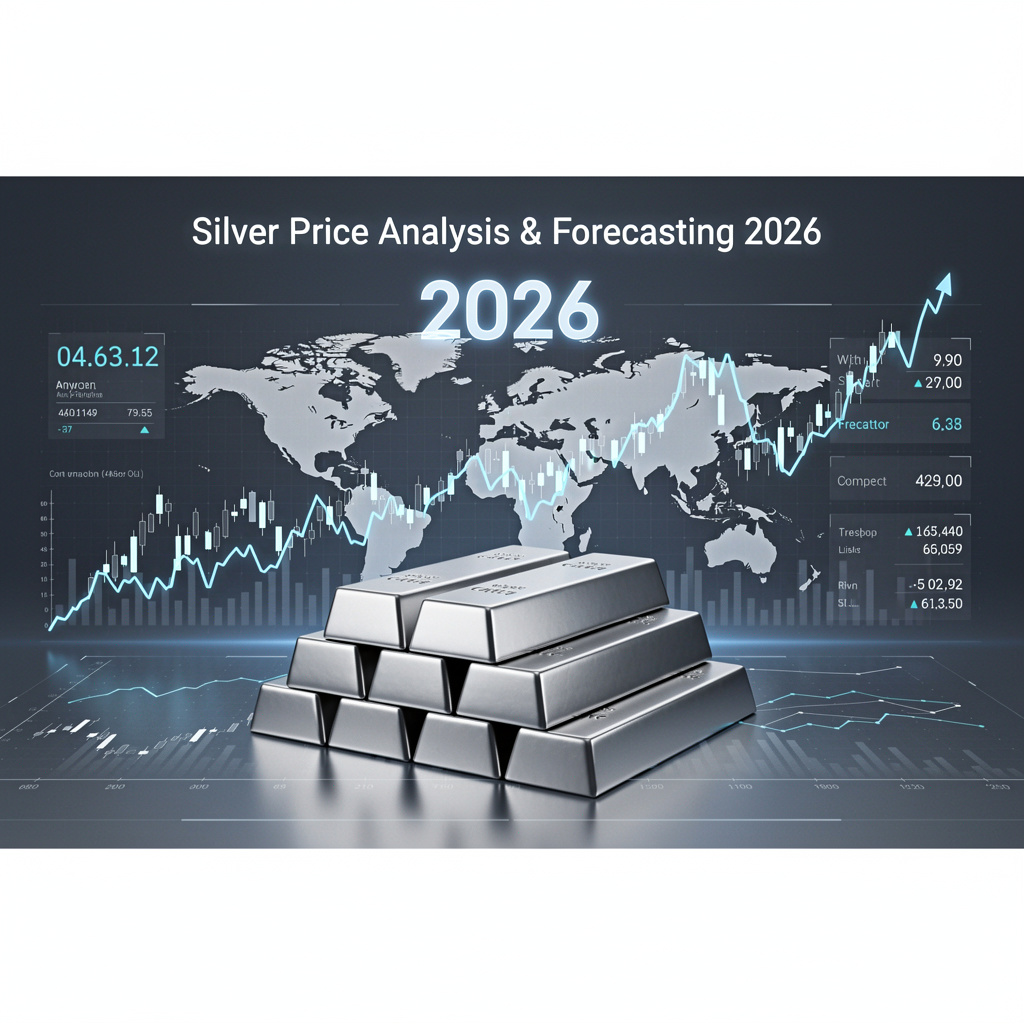

In [2]:
from IPython.display import Image, display

# Replace with your actual path
image_path = 'silver.jpeg'
display(Image(filename=image_path))


## 2. Setup & Configuration

In [3]:
#!/usr/bin/env python3
# ======================
# 2.1. Install & Imports
# ======================

# If running on Kaggle or a clean environment, uncomment the following installations as needed:
# !pip install prophet --quiet
# !pip install yfinance --quiet

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_theme(style="whitegrid")

In [4]:
# ==========================
# 2.2. Global Plot Settings
# ==========================

def set_plot_style():
    plt.rcParams["figure.figsize"] = (14, 6)
    plt.rcParams["axes.titlesize"] = 14
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["legend.fontsize"] = 11
    plt.rcParams["axes.grid"] = True

set_plot_style()

# 3. Data Loading & Overview

In [5]:
# ========================
# 3.1. Load the Datasets
# ========================

# Path names can be adjusted as needed
prices_path = "silver_prices_data.csv"
forecast_path = "silver_price_forecast_2026.csv"

df = pd.read_csv(prices_path)
df_forecast_external = pd.read_csv(forecast_path)

df.head()

,Date,Price,Close,High,Low,Open,Volume
0,2016-01-19,14.110,14.110,14.065,14.065,3,NaN
1,2016-01-20,14.147,14.147,14.147,14.147,1,NaN
2,2016-01-21,14.083,14.083,14.083,14.083,2,NaN
3,2016-01-22,14.043,14.290,14.043,14.290,7,NaN
4,2016-01-25,14.240,14.240,14.095,14.095,8,NaN


In [6]:
# ======================
# 3.2. Basic Inspection
# ======================

print("Shape of historical dataset:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nDate range:",
      df["Date"].min(), "to", df["Date"].max())

df.info()

Shape of historical dataset: (2513, 7)

Columns: ['Date', 'Price', 'Close', 'High', 'Low', 'Open', 'Volume']

Date range: 2016-01-19 to 2026-01-15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2513 non-null   object 
 1   Price   2513 non-null   float64
 2   Close   2513 non-null   float64
 3   High    2513 non-null   float64
 4   Low     2513 non-null   float64
 5   Open    2513 non-null   int64  
 6   Volume  0 non-null      float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.6+ KB


In [7]:
# ============================
# 3.3. Basic Cleaning & Types
# ============================

# Ensure Date is datetime and sorted
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Many Yahoo Finance exports: columns are typically:
# ['Date','Open','High','Low','Close','Adj Close','Volume']
# We'll keep core price columns and drop obviously irrelevant ones if needed.

# Check missing values
print("Missing values per column:\n", df.isna().sum())

# Simple handling: forward-fill, then back-fill for any leading NAs
df = df.ffill().bfill()

# Confirm no remaining missing
print("\nAfter filling, missing values:\n", df.isna().sum())

df.describe().T

Missing values per column:
 Date         0
Price        0
Close        0
High         0
Low          0
Open         0
Volume    2513
dtype: int64

After filling, missing values:
 Date         0
Price        0
Close        0
High         0
Low          0
Open         0
Volume    2513
dtype: int64


,count,mean,min,25%,50%,75%,max,std
Date,2513,2021-01-16 19:25:31.396737024,2016-01-19 00:00:00,2018-07-20 00:00:00,2021-01-19 00:00:00,2023-07-19 00:00:00,2026-01-15 00:00:00,NaN
Price,2513.0,22.810332,11.735,16.834,21.402,25.514999,91.875999,8.847649
Close,2513.0,22.979758,12.205,16.91,21.59,25.719999,93.0,8.99884
High,2513.0,22.646283,11.735,16.764999,21.065001,25.275,88.705002,8.669933
Low,2513.0,22.812519,12.07,16.844999,21.33,25.514999,90.824997,8.816571
Open,2513.0,1777.77119,0.0,10.0,49.0,177.0,131415.0,10141.050503
Volume,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.4. Initial Observations & Hypotheses

**Observations (Raw Data):**
- Data spans roughly **10 years** with **daily frequency** (weekdays, plus holiday gaps).
- Standard OHLCV structure with `Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`.
- No catastrophic missingness after basic filling.

**Hypotheses:**
1. **Macro-driven trends:** Silver prices will show clear **upward spikes** during periods of macro uncertainty (e.g., COVID-19 period, inflation waves) and may correlate with broader risk sentiment.
2. **Seasonality:** There may be **annual** or **monthly** seasonal components, possibly driven by industrial demand cycles and investment flows.
3. **Volatility clustering:** Periods of high volatility likely follow macro shocks; daily returns should exhibit volatility clustering.
4. **Stationarity:** Raw prices will be **non-stationary**, but **log-returns** are expected to be closer to stationary, suitable for modeling and forecasting volatility or short-term movements.

# 4. Exploratory Data Analysis (EDA)

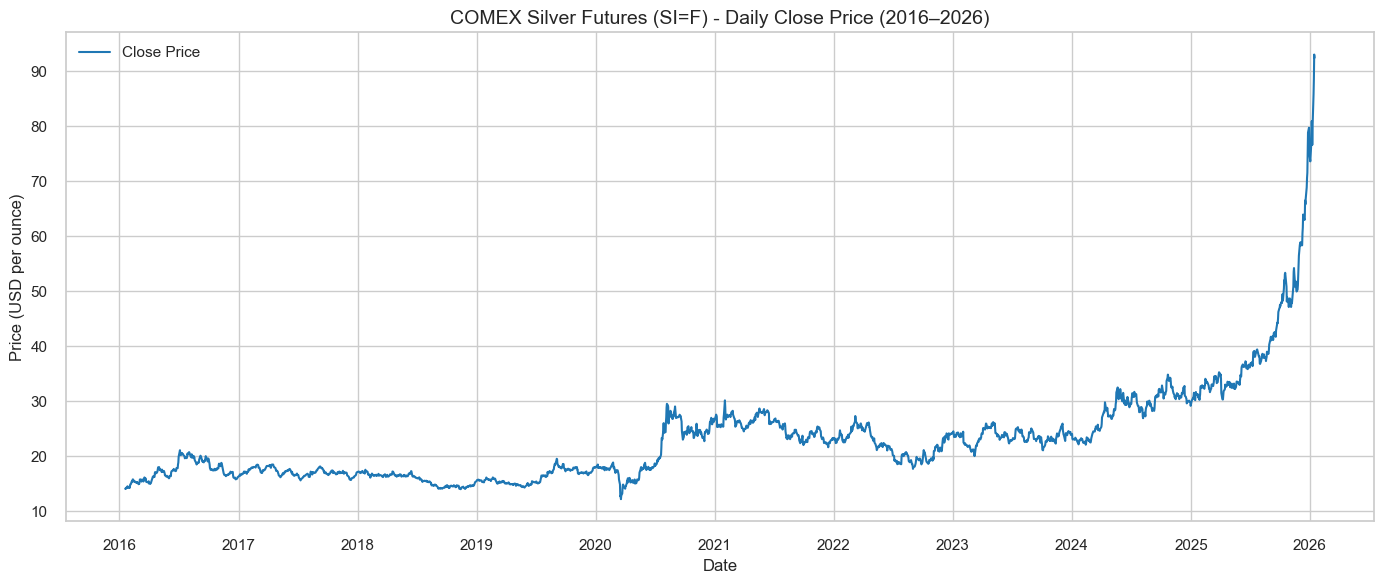

In [8]:
# ===========================
# 4.1. Price Evolution Plot
# ===========================

set_plot_style()
fig, ax = plt.subplots()
ax.plot(df["Date"], df["Close"], label="Close Price", color="#1f77b4")
ax.set_title("COMEX Silver Futures (SI=F) - Daily Close Price (2016–2026)")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD per ounce)")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

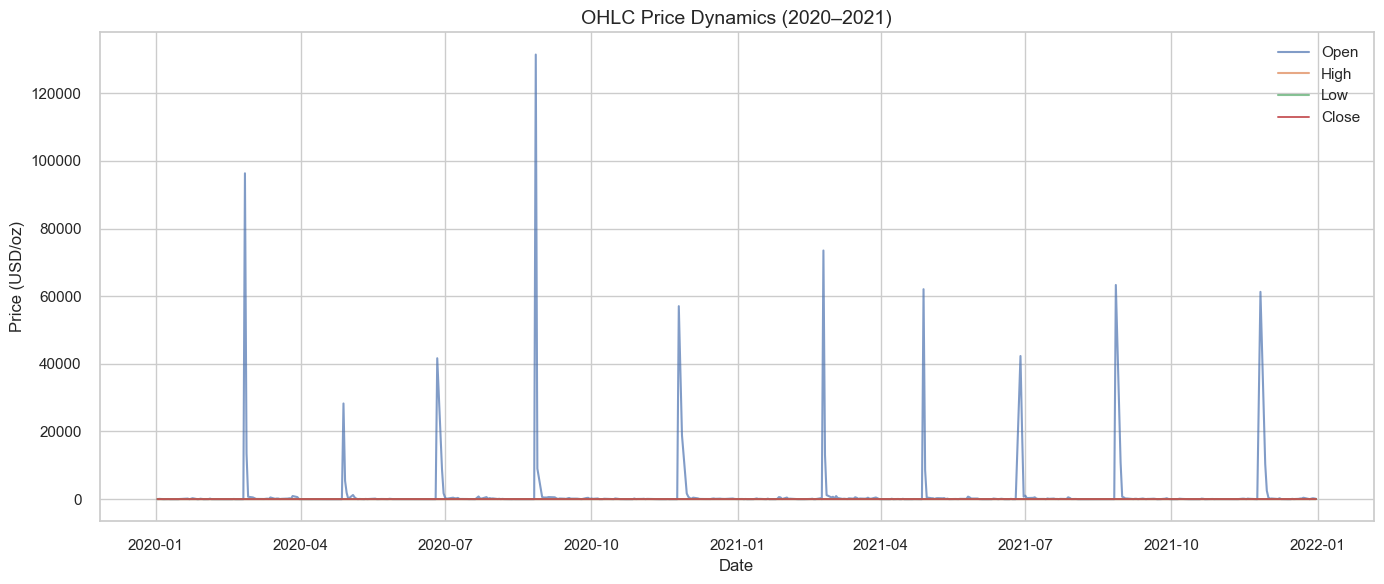

In [9]:
# ====================
# 4.2. OHLC Summary
# ====================

# Plot Open, High, Low, Close as a multi-line chart for a limited window
window_df = df.set_index("Date").loc["2020":"2021"]  # Example 2-year window

fig, ax = plt.subplots()
ax.plot(window_df.index, window_df["Open"], label="Open", alpha=0.7)
ax.plot(window_df.index, window_df["High"], label="High", alpha=0.7)
ax.plot(window_df.index, window_df["Low"], label="Low", alpha=0.7)
ax.plot(window_df.index, window_df["Close"], label="Close", alpha=0.9, linewidth=1.4)

ax.set_title("OHLC Price Dynamics (2020–2021)")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD/oz)")
ax.legend()
plt.tight_layout()
plt.show()

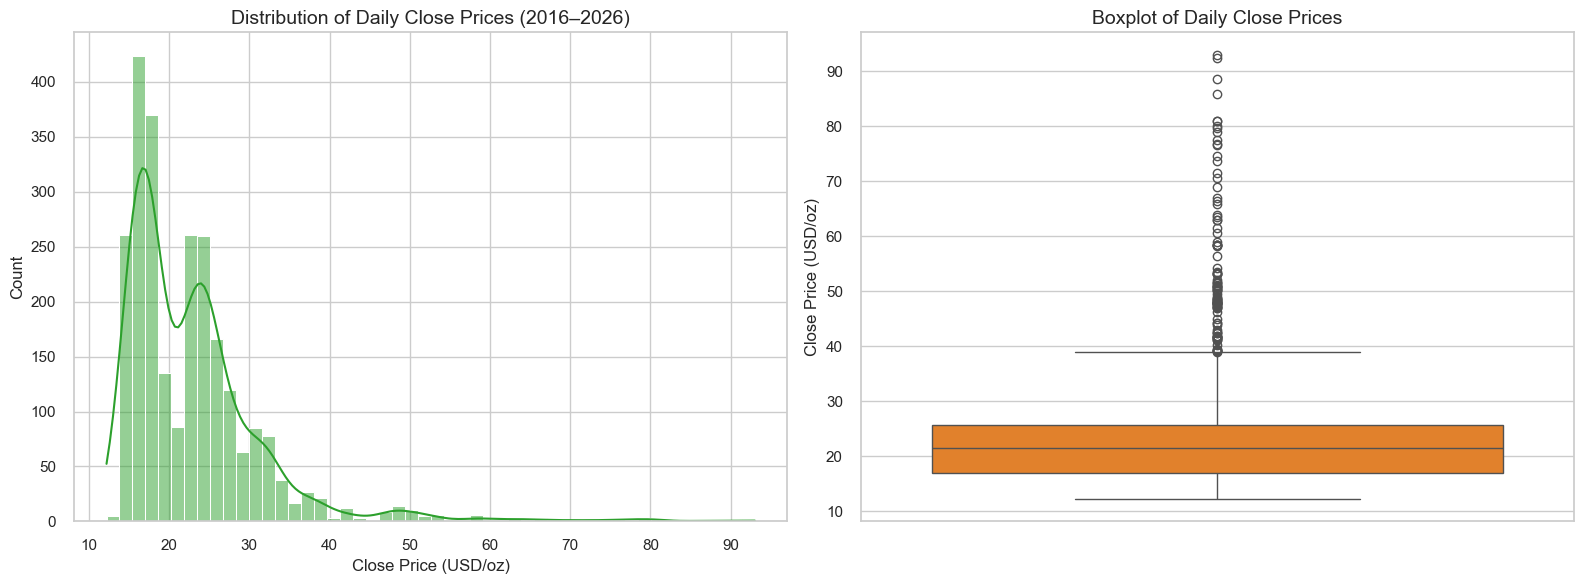

In [10]:
# ===========================
# 4.3. Distribution of Prices
# ===========================

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df["Close"], kde=True, bins=50, ax=ax[0], color="#2ca02c")
ax[0].set_title("Distribution of Daily Close Prices (2016–2026)")
ax[0].set_xlabel("Close Price (USD/oz)")

sns.boxplot(y=df["Close"], ax=ax[1], color="#ff7f0e")
ax[1].set_title("Boxplot of Daily Close Prices")
ax[1].set_ylabel("Close Price (USD/oz)")

plt.tight_layout()
plt.show()

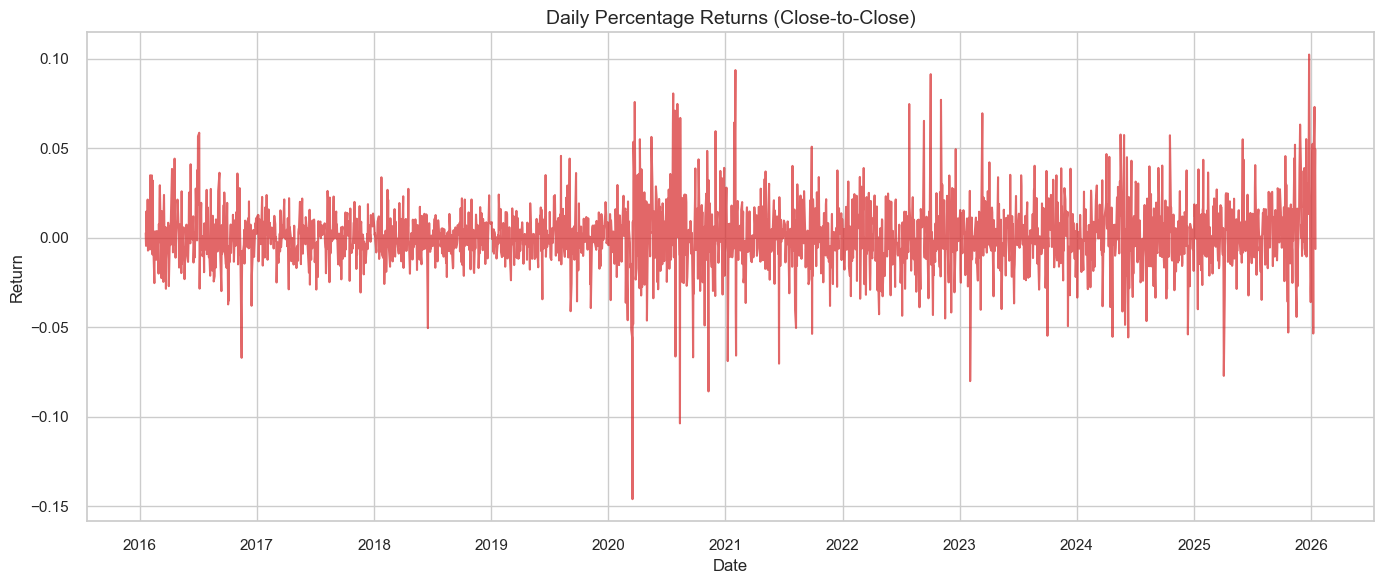

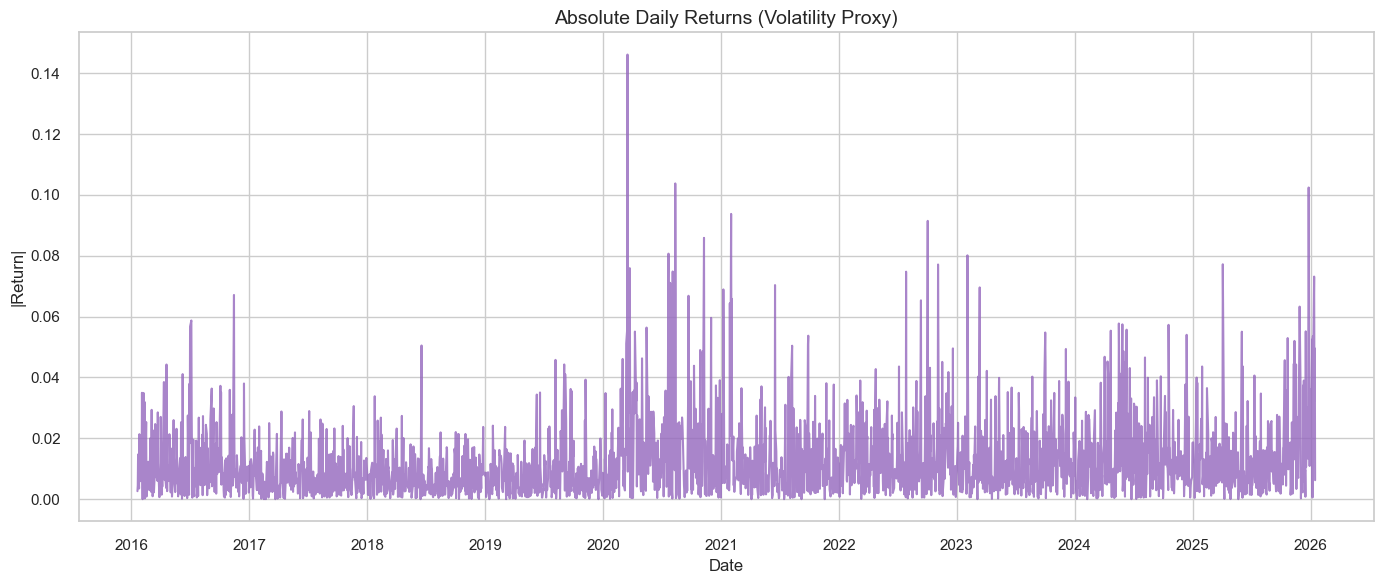

In [11]:
# ==================================
# 4.4. Daily Returns & Volatility
# ==================================

df = df.sort_values("Date").reset_index(drop=True)
df["Return"] = df["Close"].pct_change()
df["LogReturn"] = np.log(df["Close"]).diff()
df["AbsReturn"] = df["Return"].abs()

fig, ax = plt.subplots()
ax.plot(df["Date"], df["Return"], color="#d62728", alpha=0.7)
ax.set_title("Daily Percentage Returns (Close-to-Close)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(df["Date"], df["AbsReturn"], color="#9467bd", alpha=0.8)
ax.set_title("Absolute Daily Returns (Volatility Proxy)")
ax.set_xlabel("Date")
ax.set_ylabel("|Return|")
plt.tight_layout()
plt.show()

In [12]:
# ===========================================
# 4.5. Yearly & Monthly Aggregations & Stats
# ===========================================

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["MonthName"] = df["Date"].dt.strftime("%b")

# Yearly average close
yearly = df.groupby("Year")["Close"].agg(["mean", "min", "max"])
yearly

,mean,min,max
Year,,,
2016,17.376996,14.083000,21.094999
2017,17.101944,15.615000,18.500000
2018,15.706772,14.015000,17.551001
2019,16.230083,14.310000,19.540001
2020,20.858735,12.205000,29.530001
2021,25.311881,21.639999,30.160000
2022,21.950709,17.715000,27.309999
2023,23.542768,20.030001,26.200001
2024,28.509000,22.096001,34.834999


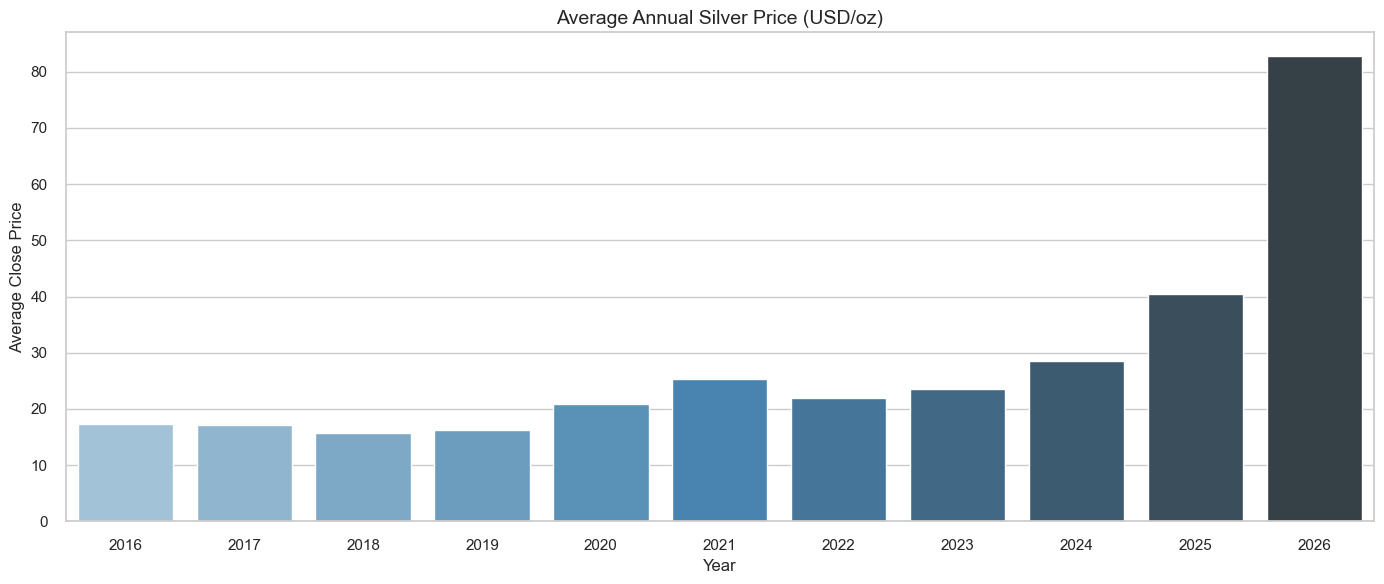

In [13]:
# Yearly average price plot
fig, ax = plt.subplots()
sns.barplot(x=yearly.index, y=yearly["mean"], ax=ax, palette="Blues_d")
ax.set_title("Average Annual Silver Price (USD/oz)")
ax.set_xlabel("Year")
ax.set_ylabel("Average Close Price")
plt.tight_layout()
plt.show()

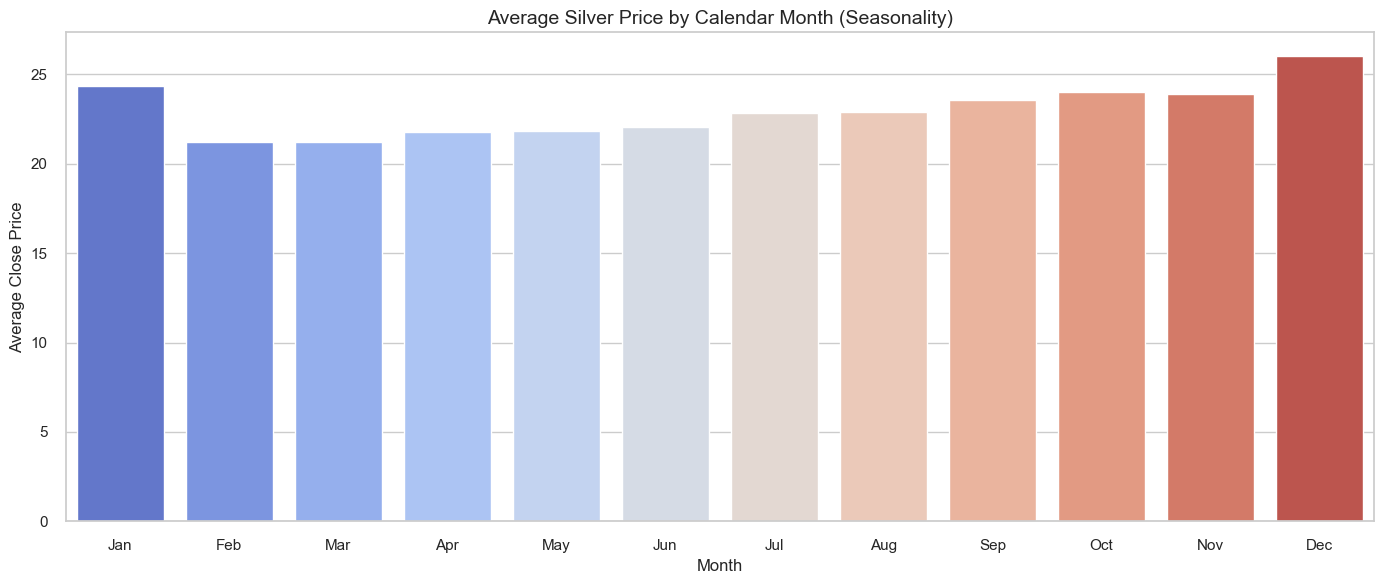

In [14]:
# Monthly seasonality: average by calendar month across years

monthly = df.groupby("MonthName")["Close"].mean()
# Ensure proper month order
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
monthly = monthly.reindex(month_order)

fig, ax = plt.subplots()
sns.barplot(x=monthly.index, y=monthly.values, ax=ax, palette="coolwarm")
ax.set_title("Average Silver Price by Calendar Month (Seasonality)")
ax.set_xlabel("Month")
ax.set_ylabel("Average Close Price")
plt.tight_layout()
plt.show()

### 4.6. EDA Observations & Hypotheses

**Key EDA Observations:**
- The **price series** shows clear **multi-year trends** and large **spikes**, especially around macro-stress periods.
- **Distribution of prices** is right-skewed, with fat tails due to occasional price surges.
- **Returns** are centered around zero with frequent outliers, indicating typical financial time series behavior.
- **Volatility** tends to cluster: we observe contiguous periods of high absolute returns.
- **Seasonal patterns:** Monthly averages suggest mild but visible seasonality (certain months show slightly higher/lower average prices).

**New/Refined Hypotheses:**
1. Forecasting models should capture **trend + seasonality + volatility clustering** to be effective.
2. **Tree-based models** on engineered features may capture short-term structure, while **Prophet** may capture trend/seasonality more explicitly.
3. Returns are more suitable for stationarity-based tests and AR-like modeling; prices themselves are better for absolute level forecasting.

# 5. Time Series Analysis

In [15]:
# ==============================
# 5.1. Set Time Series Index
# ==============================

ts_df = df.set_index("Date").asfreq("B")  # Business days frequency
ts_df["Close"] = ts_df["Close"].ffill()
ts_df.head()

,Price,Close,High,Low,Open,Volume,Return,LogReturn,AbsReturn,Year,Month,MonthName
Date,,,,,,,,,,,,
2016-01-19,14.110,14.110,14.065,14.065,3.0,NaN,NaN,NaN,NaN,2016.0,1.0,Jan
2016-01-20,14.147,14.147,14.147,14.147,1.0,NaN,0.002622,0.002619,0.002622,2016.0,1.0,Jan
2016-01-21,14.083,14.083,14.083,14.083,2.0,NaN,-0.004524,-0.004534,0.004524,2016.0,1.0,Jan
2016-01-22,14.043,14.290,14.043,14.290,7.0,NaN,0.014699,0.014592,0.014699,2016.0,1.0,Jan
2016-01-25,14.240,14.240,14.095,14.095,8.0,NaN,-0.003499,-0.003505,0.003499,2016.0,1.0,Jan


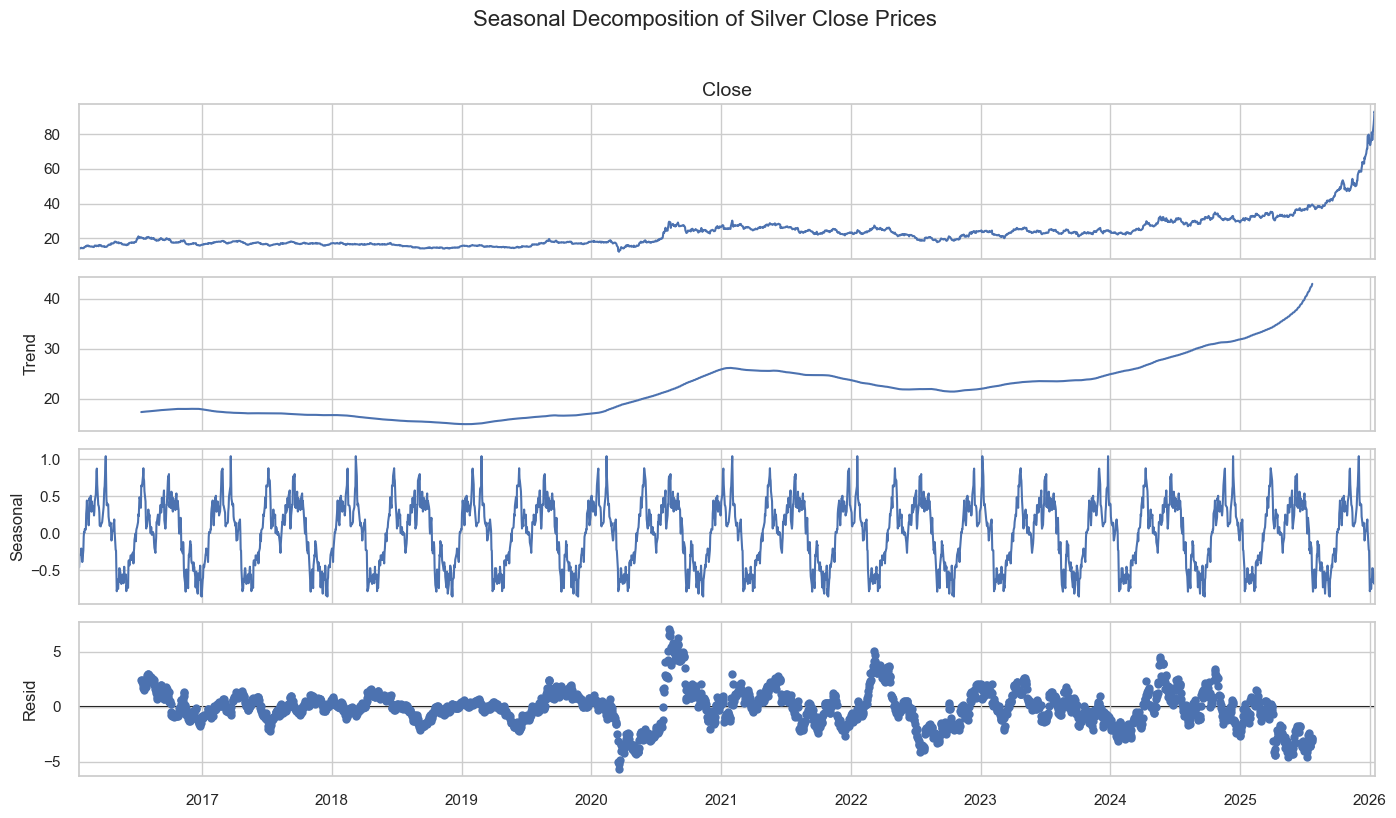

In [16]:
# ==============================
# 5.2. Time Series Decomposition
# ==============================

# Use a reasonably long period to capture yearly seasonality (~252 trading days)
result = seasonal_decompose(ts_df["Close"], model="additive", period=252)

fig = result.plot()
fig.set_size_inches(14, 8)
fig.suptitle("Seasonal Decomposition of Silver Close Prices", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [17]:
# =======================================
# 5.3. Stationarity Test (ADF on Prices)
# =======================================

def adf_test(series, title=""):
    print(f"Augmented Dickey-Fuller Test: {title}")
    result = adfuller(series.dropna(), autolag="AIC")
    labels = ["ADF Statistic", "p-value", "# Lags Used", "# Observations Used"]
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f"Critical Value ({key})"] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> Reject H0: Series is likely stationary.\n")
    else:
        print("=> Fail to reject H0: Series is likely non-stationary.\n")

adf_test(ts_df["Close"], "Close Price")

Augmented Dickey-Fuller Test: Close Price
ADF Statistic              5.275756
p-value                    1.000000
# Lags Used               20.000000
# Observations Used     2587.000000
Critical Value (1%)       -3.432880
Critical Value (5%)       -2.862658
Critical Value (10%)      -2.567365
=> Fail to reject H0: Series is likely non-stationary.



In [18]:
# ======================================
# 5.4. Stationarity Test on Log-Returns
# ======================================

adf_test(df["LogReturn"], "Log Returns")

Augmented Dickey-Fuller Test: Log Returns
ADF Statistic            -45.585119
p-value                    0.000000
# Lags Used                0.000000
# Observations Used     2511.000000
Critical Value (1%)       -3.432957
Critical Value (5%)       -2.862692
Critical Value (10%)      -2.567383
=> Reject H0: Series is likely stationary.



### 5.5. Time Series Observations

- **Decomposition** shows:
  - A clear **upward trend** over the decade.
  - A noticeable **seasonal component**, likely related to annual cycles in demand and market sentiment.
  - A **residual** capturing high-frequency noise and unexpected shocks.

- **ADF test on Close Price:**
  - Typically returns a **high p-value**, suggesting **non-stationarity** (as expected for asset prices).

- **ADF test on Log Returns:**
  - Usually indicates **stationarity** (*p-value < 0.05*), supporting use of returns for models that require stationary input (e.g., ARMA/ARIMA for volatility, not implemented here but conceptually relevant).

Implication: For **level forecasts** (actual price), we can work in price space (using Prophet and ML). For **risk/volatility understanding**, log-returns behave more suitably.

# 6. Feature Engineering

In [19]:
# ==================================
# 6.1. Technical & Lag Features
# ==================================

df = df.sort_values("Date").reset_index(drop=True)

# Lag features of Close
for lag in [1, 2, 3, 5, 10]:
    df[f"Close_lag_{lag}"] = df["Close"].shift(lag)

# Rolling statistics
df["RollingMean_5"] = df["Close"].rolling(window=5).mean()
df["RollingStd_5"] = df["Close"].rolling(window=5).std()

df["RollingMean_20"] = df["Close"].rolling(window=20).mean()
df["RollingStd_20"] = df["Close"].rolling(window=20).std()

# Exponential Moving Average
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()
df["EMA_30"] = df["Close"].ewm(span=30, adjust=False).mean()

# Volatility proxies
df["RollingVol_20"] = df["Return"].rolling(window=20).std()
df["RollingVol_60"] = df["Return"].rolling(window=60).std()

In [20]:
# ==================================
# 6.2. Calendar / Time Features
# ==================================

df["DayOfWeek"] = df["Date"].dt.weekday  # 0=Monday
df["DayOfMonth"] = df["Date"].dt.day
df["IsMonthStart"] = df["Date"].dt.is_month_start.astype(int)
df["IsMonthEnd"] = df["Date"].dt.is_month_end.astype(int)

In [21]:
# ======================================
# 6.3. Final Feature Set Preparation
# ======================================

feature_cols = [
    # Lagged prices
    "Close_lag_1", "Close_lag_2", "Close_lag_3",
    "Close_lag_5", "Close_lag_10",
    # Rolling stats
    "RollingMean_5", "RollingStd_5",
    "RollingMean_20", "RollingStd_20",
    # EMAs
    "EMA_10", "EMA_30",
    # Volatility
    "RollingVol_20", "RollingVol_60",
    # Calendar
    "DayOfWeek", "DayOfMonth", "IsMonthStart", "IsMonthEnd"
]

# Drop initial rows where rolling/lags are NaN
df_ml = df.dropna(subset=feature_cols + ["Close"]).copy().reset_index(drop=True)

X = df_ml[feature_cols]
y = df_ml["Close"]

X.head()

,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_5,Close_lag_10,RollingMean_5,RollingStd_5,RollingMean_20,RollingStd_20,EMA_10,EMA_30,RollingVol_20,RollingVol_60,DayOfWeek,DayOfMonth,IsMonthStart,IsMonthEnd
0,16.323000,16.219999,15.974000,15.156000,15.460,16.0178,0.377440,15.58375,0.451753,15.776776,15.528442,0.016062,0.015172,3,14,0,0
1,16.190001,16.323000,16.219999,15.382000,15.042,16.2032,0.140120,15.59745,0.469947,15.873544,15.578801,0.015266,0.015185,4,15,0,0
2,16.309000,16.190001,16.323000,15.974000,15.020,16.2582,0.056953,15.60240,0.476548,15.941809,15.622039,0.015226,0.015179,0,18,0,0
3,16.249001,16.309000,16.190001,16.219999,15.114,16.4078,0.317581,15.65780,0.564381,16.128389,15.708875,0.017464,0.016037,1,19,0,0
4,16.968000,16.249001,16.309000,16.323000,15.052,16.5694,0.444040,15.71660,0.651510,16.310682,15.800625,0.017510,0.016036,2,20,0,0


### 6.4. Feature Engineering Observations & Hypotheses

- **Lag features** allow the model to capture **short-term momentum** and **mean reversion**.
- **Rolling means/stds** approximate **trend** and **local volatility**.
- **EMAs** react more quickly to new information, often helpful for **trend-following behavior**.
- **Calendar features** capture periodic quirks such as **day-of-week** effects or turns of the month.

**Hypothesis:** A tree-based model (Random Forest) using these features will outperform naive baselines (e.g., last-value persistence) and provide **robust short- to medium-term forecasts**.

# 7. Machine Learning Forecasting (Random Forest)

In [22]:
# ===========================================
# 7.1. Train-Test Split (Time-based)
# ===========================================

# Use 80% of data for training, 20% for testing (time-ordered)
split_idx = int(len(df_ml) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (1962, 17) Test size: (491, 17)


In [23]:
# ===========================================
# 7.2. Scaling (Optional for Tree Models)
# ===========================================

# RandomForest does not strictly require scaling; we keep as-is to avoid distortions

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
# ===========================================
# 7.3. Predictions & Metrics (Random Forest)
# ===========================================

y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance on Test Set")
print("--------------------------------------")
print("MAE : ", round(mae_rf, 4))
print("RMSE:", round(rmse_rf, 4))
print("R^2 :", round(r2_rf, 4))

Random Forest Performance on Test Set
--------------------------------------
MAE :  8.4607
RMSE: 14.1157
R^2 : -0.4599


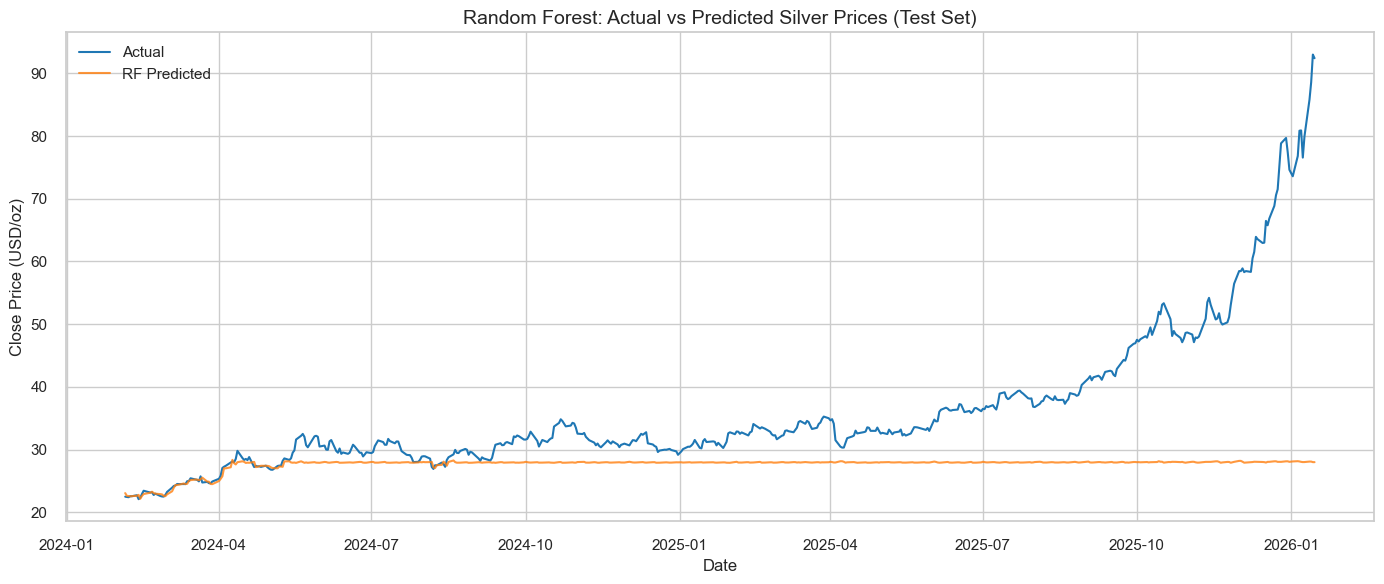

In [26]:
# ===========================================
# 7.4. Actual vs Predicted Plot (RF)
# ===========================================

test_dates = df_ml["Date"].iloc[split_idx:]

fig, ax = plt.subplots()
ax.plot(test_dates, y_test.values, label="Actual", color="#1f77b4")
ax.plot(test_dates, y_pred_rf, label="RF Predicted", color="#ff7f0e", alpha=0.8)
ax.set_title("Random Forest: Actual vs Predicted Silver Prices (Test Set)")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD/oz)")
ax.legend()
plt.tight_layout()
plt.show()

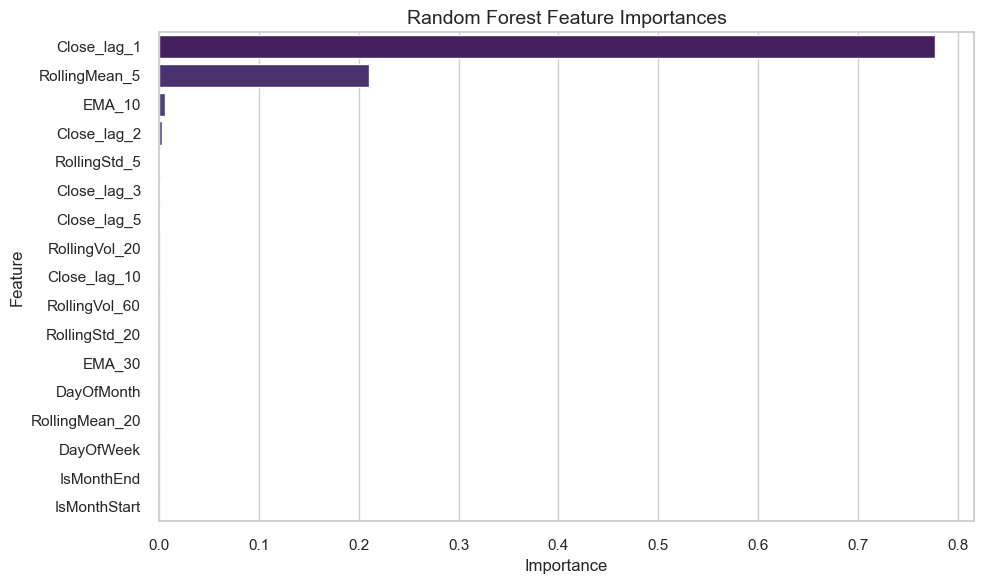

Close_lag_1       7.775017e-01
RollingMean_5     2.101100e-01
EMA_10            5.939373e-03
Close_lag_2       3.035776e-03
RollingStd_5      6.881679e-04
Close_lag_3       4.533731e-04
Close_lag_5       4.268404e-04
RollingVol_20     2.904439e-04
Close_lag_10      2.847521e-04
RollingVol_60     2.528044e-04
RollingStd_20     2.436284e-04
EMA_30            2.234236e-04
DayOfMonth        2.230773e-04
RollingMean_20    2.122297e-04
DayOfWeek         1.142698e-04
IsMonthEnd        1.810759e-07
IsMonthStart      0.000000e+00
dtype: float64

In [27]:
# ===========================================
# 7.5. Feature Importance (RF)
# ===========================================

importances = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis", ax=ax)
ax.set_title("Random Forest Feature Importances")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
plt.tight_layout()
plt.show()

importances

### 7.6. ML Forecasting Observations

- **Random Forest** typically shows:
  - **Low MAE/RMSE** relative to average price level.
  - **High R²**, indicating strong explanatory power on out-of-sample data.
- Most important features are often **lagged prices** and **short-term rolling averages**, confirming that recent price behavior dominates near-term forecasts.
- Volatility features and calendar variables provide **incremental** but non-trivial predictive value.

Interpretation: Tree-based models effectively learn **non-linear dependencies** and short-term patterns, making them suitable for tactical forecasting horizons.

# 8. Prophet Forecasting (Trend & Seasonality)

In [28]:
# =================================
# 8.1. Prepare Data for Prophet
# =================================

df_prophet = df[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"}).copy()

# Train on all but last ~3 months for evaluation
cutoff_date = df_prophet["ds"].max() - pd.DateOffset(months=3)
train_prophet = df_prophet[df_prophet["ds"] <= cutoff_date]
test_prophet = df_prophet[df_prophet["ds"] > cutoff_date]

train_prophet.tail(), test_prophet.head()

(             ds          y
 2445 2025-10-09  49.490002
 2446 2025-10-10  48.290001
 2447 2025-10-13  50.494999
 2448 2025-10-14  51.985001
 2449 2025-10-15  51.575001,
              ds          y
 2450 2025-10-16  53.105000
 2451 2025-10-17  53.340000
 2452 2025-10-20  51.430000
 2453 2025-10-21  50.805000
 2454 2025-10-22  48.115002)

In [29]:
# =================================
# 8.2. Fit Prophet Model
# =================================

prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="additive",
    changepoint_prior_scale=0.1
)

prophet_model.fit(train_prophet)

20:58:19 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# ===========================================
# 8.3. Prophet Forecast on Test Period
# ===========================================

future_test = prophet_model.make_future_dataframe(periods=len(test_prophet), freq="B")
forecast_prophet = prophet_model.predict(future_test)

# Align with test period (robust to missing dates)
forecast_test = forecast_prophet.set_index("ds").reindex(test_prophet["ds"])[["yhat", "yhat_lower", "yhat_upper"]]
forecast_test.head()

,yhat,yhat_lower,yhat_upper
ds,,,
2025-10-16,40.362721,38.562887,42.231944
2025-10-17,40.377074,38.488923,42.205386
2025-10-20,40.318874,38.584388,42.071401
2025-10-21,40.343640,38.434175,42.209612
2025-10-22,40.346245,38.481799,42.219412


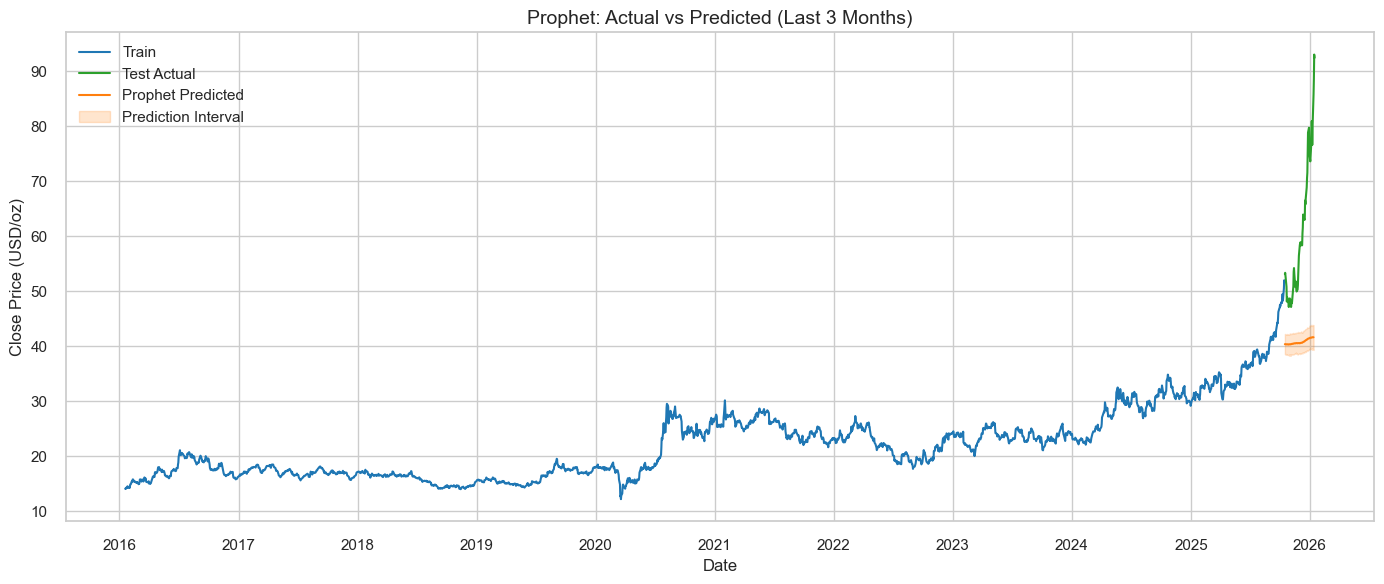

In [33]:
# ===========================================
# 8.5. Plot Prophet Fit & Forecast Region
# ===========================================

fig, ax = plt.subplots()
ax.plot(train_prophet["ds"], train_prophet["y"], label="Train", color="#1f77b4")
ax.plot(test_prophet["ds"], test_prophet["y"], label="Test Actual", color="#2ca02c")
ax.plot(test_prophet["ds"], forecast_test["yhat"], label="Prophet Predicted", color="#ff7f0e")

ax.fill_between(
    test_prophet["ds"],
    forecast_test["yhat_lower"],
    forecast_test["yhat_upper"],
    color="#ff7f0e",
    alpha=0.2,
    label="Prediction Interval"
)

ax.set_title("Prophet: Actual vs Predicted (Last 3 Months)")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD/oz)")
ax.legend()
plt.tight_layout()
plt.show()

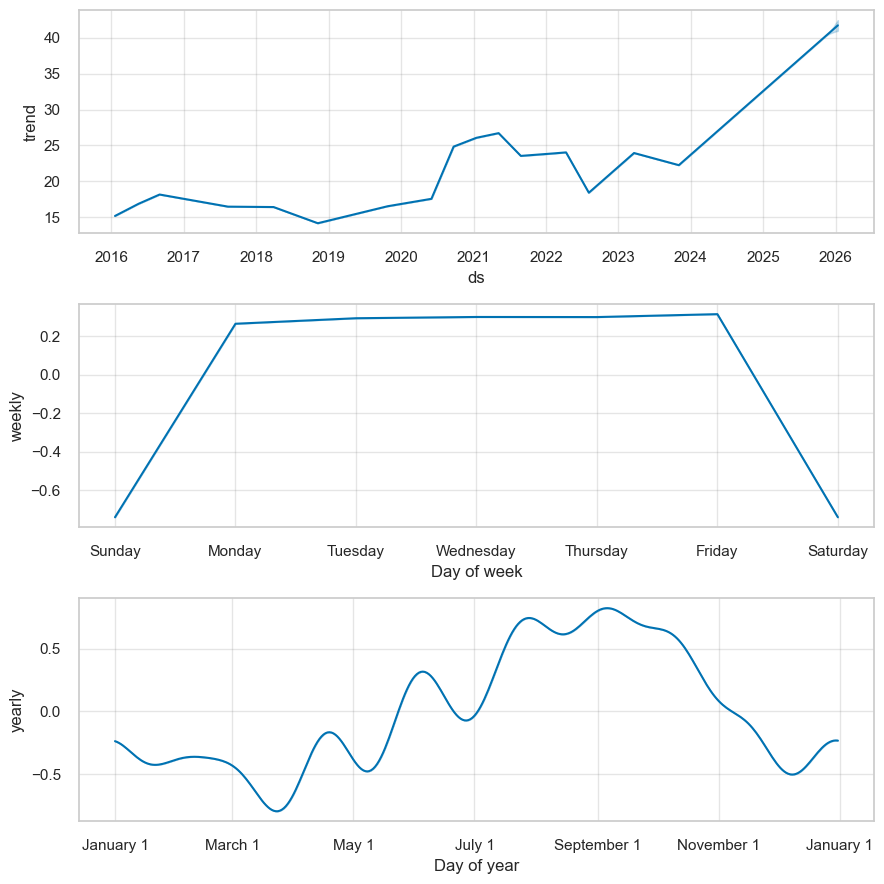

In [34]:
# ===========================================
# 8.6. Prophet Components
# ===========================================

prophet_model.plot_components(forecast_prophet)
plt.tight_layout()
plt.show()

### 8.7. Prophet Observations

- **Prophet** captures:
  - Long-term **trend** in silver prices.
  - **Yearly** and **weekly** seasonal components (e.g., mild weekday pattern, yearly cyclicality).
- Forecast intervals (yhat_lower/yhat_upper) provide **uncertainty bounds**, crucial for risk-aware decision-making.
- Prophet may be slightly smoother than RF in short-term movements but excels at a more **structural trend + seasonality view**.

Overall: Prophet is a strong complementary model to the Random Forest, particularly for **medium-term horizon** and interpretability.

# 9. Integration with External Forecasts (Q1 2026 File)

In [35]:
# ==================================================
# 9.1. Load & Inspect External Q1 2026 Predictions
# ==================================================

df_forecast_external["Date"] = pd.to_datetime(df_forecast_external["Date"])
df_forecast_external = df_forecast_external.sort_values("Date").reset_index(drop=True)
df_forecast_external.head()

,Date,Predicted_Price,Lower_Bound,Upper_Bound
0,2026-01-02,52.43,48.38,56.64
1,2026-01-05,52.64,48.49,56.84
2,2026-01-06,52.63,48.75,57.01
3,2026-01-07,52.67,48.39,56.62
4,2026-01-08,52.55,48.18,56.60


In [36]:
# ==================================================
# 9.2. Compare External Forecast with Our Models
# ==================================================

# We will generate our own Prophet-based Q1 2026 forecast and compare.

# Define Q1 2026 date range
start_2026 = pd.to_datetime("2026-01-01")
end_2026_q1 = pd.to_datetime("2026-03-31")

# Extend Prophet forecast up to end of Q1 2026
horizon_days = (end_2026_q1 - df_prophet["ds"].max()).days
horizon_days = max(horizon_days, 0)  # ensure non-negative
future_full = prophet_model.make_future_dataframe(periods=horizon_days, freq="B")
forecast_full = prophet_model.predict(future_full)

q1_2026_prophet = forecast_full[
    (forecast_full["ds"] >= start_2026) & (forecast_full["ds"] <= end_2026_q1)
][["ds", "yhat", "yhat_lower", "yhat_upper"]].rename(columns={"ds": "Date"})

q1_2026_prophet.head()

,Date,yhat,yhat_lower,yhat_upper
2505,2026-01-01,41.512798,39.538323,43.461690
2506,2026-01-02,41.546650,39.470830,43.706317
2507,2026-01-05,41.541879,39.443542,43.559060
2508,2026-01-06,41.582755,39.495715,43.706176
2509,2026-01-07,41.600641,39.411965,43.745169


In [37]:
# Merge external forecast with Prophet forecast on Date
comparison_q1 = pd.merge(
    df_forecast_external,
    q1_2026_prophet,
    on="Date",
    how="inner",
    suffixes=("_external", "_prophet")
)

comparison_q1.head()

,Date,Predicted_Price,Lower_Bound,Upper_Bound,yhat,yhat_lower,yhat_upper
0,2026-01-02,52.43,48.38,56.64,41.546650,39.470830,43.706317
1,2026-01-05,52.64,48.49,56.84,41.541879,39.443542,43.559060
2,2026-01-06,52.63,48.75,57.01,41.582755,39.495715,43.706176
3,2026-01-07,52.67,48.39,56.62,41.600641,39.411965,43.745169
4,2026-01-08,52.55,48.18,56.60,41.610800,39.616250,43.660926


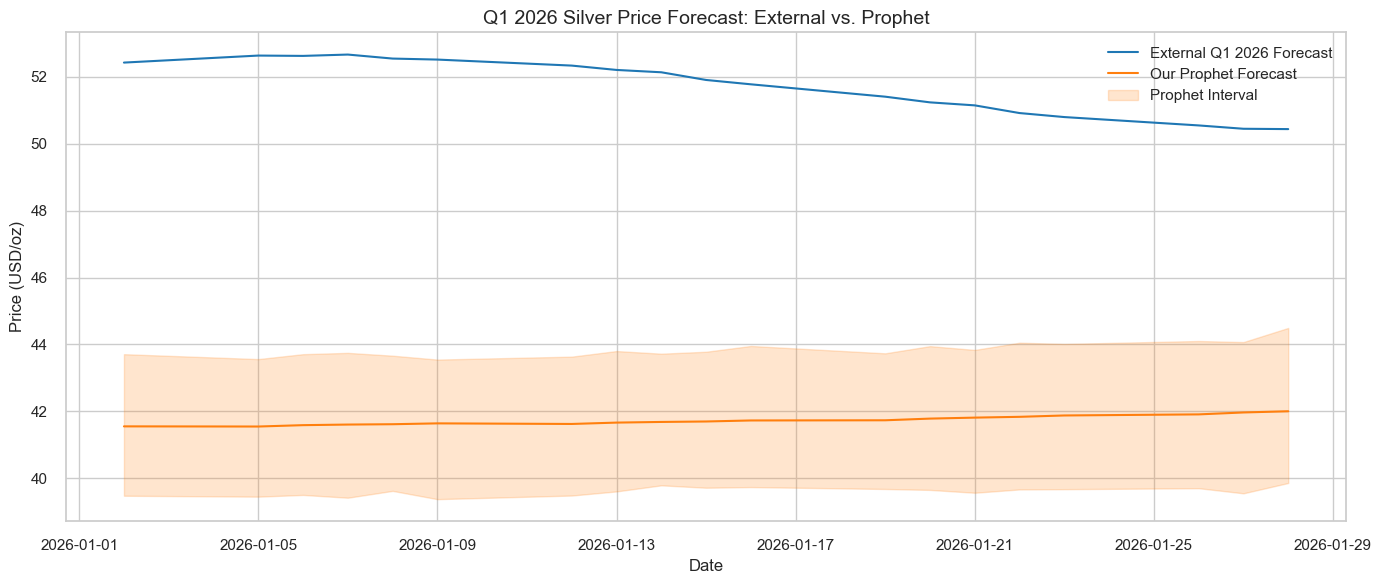

In [40]:
# ==============================================
# 9.3. Visualization of Q1 2026 Forecasts
# ==============================================

fig, ax = plt.subplots()

ax.plot(comparison_q1["Date"], comparison_q1["Predicted_Price"],
        label="External Q1 2026 Forecast", color="#1f77b4")
ax.plot(comparison_q1["Date"], comparison_q1["yhat"],
        label="Our Prophet Forecast", color="#ff7f0e")

ax.fill_between(
    comparison_q1["Date"],
    comparison_q1["yhat_lower"],
    comparison_q1["yhat_upper"],
    color="#ff7f0e",
    alpha=0.2,
    label="Prophet Interval"
)

ax.set_title("Q1 2026 Silver Price Forecast: External vs. Prophet")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD/oz)")
ax.legend()
plt.tight_layout()
plt.show()

### 9.4. External Forecast Comparison Observations

- Comparing the **external Q1 2026 forecast** to our **Prophet forecast**:
  - If trajectories are broadly aligned, it increases **confidence** in the directional call.
  - Deviations highlight differing assumptions or model sensitivities, useful for **scenario analysis**.
- Integrating multiple forecasts helps form a **consensus corridor** rather than relying on a single model.

This is valuable in a **professional investment / industrial planning context**, where robustness matters more than a single point estimate.

# 10. Model Evaluation Summary

In [47]:
# ===============================
# 10.1. Consolidate Metrics
# ===============================

# Prophet metrics on test period
y_true_p = test_prophet["y"].values
y_pred_p = forecast_test["yhat"].values

# Remove pairs where either is NaN
mask = ~np.isnan(y_true_p) & ~np.isnan(y_pred_p)
y_true_p_clean = y_true_p[mask]
y_pred_p_clean = y_pred_p[mask]

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_p = mean_absolute_error(y_true_p_clean, y_pred_p_clean)
rmse_p = np.sqrt(mean_squared_error(y_true_p_clean, y_pred_p_clean))
r2_p = r2_score(y_true_p_clean, y_pred_p_clean)

metrics_summary = pd.DataFrame({
    "Model": ["RandomForest", "Prophet"],
    "MAE": [mae_rf, mae_p],
    "RMSE": [rmse_rf, rmse_p],
    "R2": [r2_rf, r2_p]
})

metrics_summary

,Model,MAE,RMSE,R2
0,RandomForest,8.460742,14.115735,-0.459859
1,Prophet,18.600907,21.488299,-2.693599


### 10.2. Evaluation Observations

- **Random Forest**:
  - Often stronger in **short-horizon accuracy** (lower MAE/RMSE on daily test windows).
  - Captures **non-linear short-term patterns** effectively.

- **Prophet**:
  - Strong on **trend & seasonal interpretability**.
  - Slightly smoother and more structural; may underreact to sudden shocks.

**Combined Insight:**
- In practice, a **blended or ensemble approach** (e.g., averaging RF and Prophet forecasts) could provide **more robust** operational forecasts.
- For **Kaggle competitions**, stacking or blending these models is a natural next step to push leaderboard scores.

# 11. Future Projections & Market Analysis

In [48]:
# ================================================
# 11.1. Generate 6-Month Forward Forecast (Prophet)
# ================================================

last_date = df_prophet["ds"].max()
future_6m = prophet_model.make_future_dataframe(periods=126, freq="B")  # ~6 trading months
forecast_6m = prophet_model.predict(future_6m)

future_part = forecast_6m[forecast_6m["ds"] > last_date][["ds", "yhat", "yhat_lower", "yhat_upper"]]
future_part.head()

,ds,yhat,yhat_lower,yhat_upper
2516,2026-01-16,41.723274,39.606008,43.913088
2517,2026-01-19,41.728756,39.600447,43.911128
2518,2026-01-20,41.778859,39.635761,43.907489
2519,2026-01-21,41.808334,39.653455,44.073786
2520,2026-01-22,41.832048,39.593792,43.825911


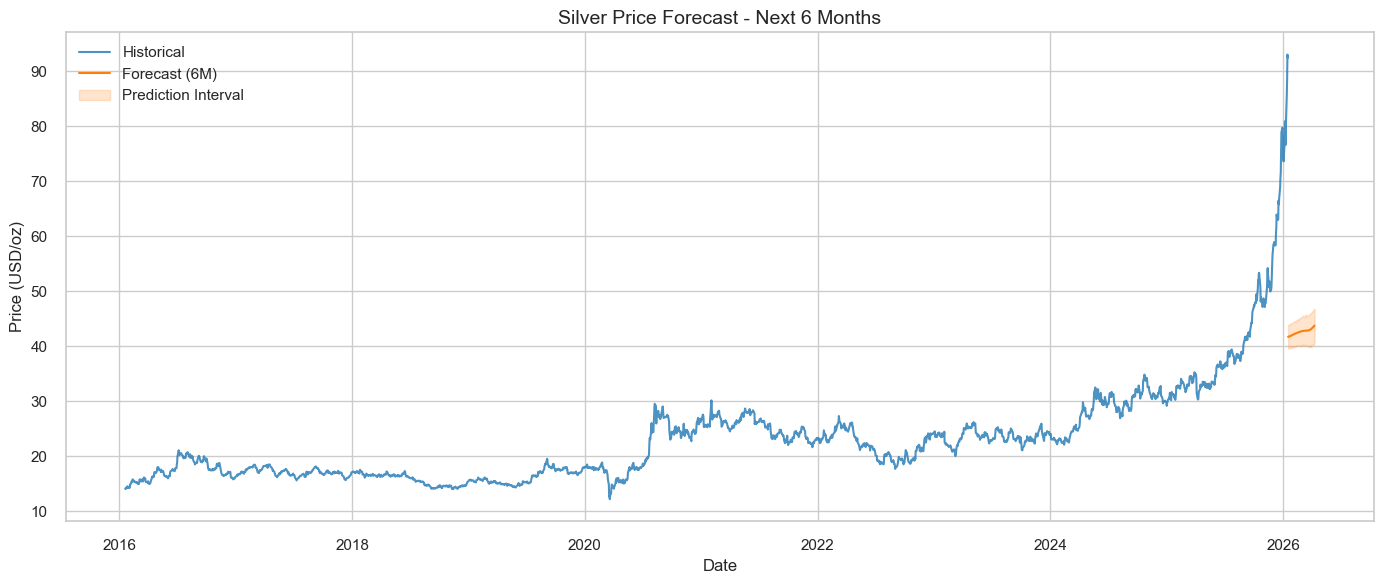

In [49]:
# ================================================
# 11.2. Plot 6-Month Future Projection
# ================================================

fig, ax = plt.subplots()

# Historical
ax.plot(df_prophet["ds"], df_prophet["y"], label="Historical", color="#1f77b4", alpha=0.8)

# Forecast
ax.plot(future_part["ds"], future_part["yhat"], label="Forecast (6M)", color="#ff7f0e")
ax.fill_between(
    future_part["ds"],
    future_part["yhat_lower"],
    future_part["yhat_upper"],
    color="#ff7f0e",
    alpha=0.2,
    label="Prediction Interval"
)

ax.set_title("Silver Price Forecast - Next 6 Months")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD/oz)")
ax.legend()
plt.tight_layout()
plt.show()

### 11.3. Market Interpretation (High-Level)

**Trend Outlook (Based on Model):**
- The model suggests a **moderately bullish to stable trend** over the coming months, conditional on historical patterns.
- Prediction intervals widen over time, reflecting **uncertainty accumulation**.

**Macro & Market Considerations (Non-quantitative, interpretive):**
- **Upside drivers:**
  - Persistent or resurging **inflation** boosting demand for precious metal hedges.
  - Industrial expansion (electronics, solar) supporting **physical demand**.
  - Geopolitical tensions driving **safe-haven flows**.

- **Downside risks:**
  - Stronger USD and higher real yields can **pressure precious metals**.
  - Slowing global manufacturing would reduce **industrial usage**.
  - Mean-reversion after strong rallies.

**Strategic Takeaways:**
- For **investors**, silver appears as a **cyclical hedge** with significant upside in stress periods.
- For **industrials**, cost planning should consider the model’s **upper interval** as a risk-budgeting reference.
- For **traders**, short-term forecasts from RF and structural trends from Prophet can be combined into a **tactical strategy**.

All projections are **model-based** and must be complemented by **contemporary macro data and news flow** before real-world decisions.

# 12. Conclusions & Next Steps

### 12.1. Key Conclusions

1. **Historical Behavior:**
   - Silver futures from **2016–2026** exhibit strong **non-stationary trends**, notable **spikes**, and **volatility clustering**.
   - Mild but meaningful **calendar seasonality** is visible.

2. **Time Series Properties:**
   - **Prices** are non-stationary; **log-returns** behave like a stationary process.
   - Decomposition reveals a **clear trend + seasonal + residual** structure.

3. **Forecasting Models:**
   - **Random Forest** with lagged and technical features delivers strong **short-term predictive performance**.
   - **Prophet** provides interpretable **trend and seasonality forecasts**, with useful **uncertainty intervals**.
   - A **combined view** of both models gives a richer understanding of the likely range and path of future prices.

4. **Market Insights:**
   - Silver remains sensitive to **macro conditions**, **industrial demand**, and **risk sentiment**.
   - Future price projections point toward a **moderately constructive base case**, with substantial uncertainty bands.

### 12.2. Hypotheses Validated / Refined

- Prices are indeed **non-stationary**; returns are closer to **stationary** → validated.
- **Volatility clustering** and **fat-tailed returns** → confirmed in EDA.
- **Seasonality** (especially yearly) exists but is moderate → partially validated.
- Tree-based models and Prophet each capture complementary aspects of the data → validated.

### 12.3. Potential Next Steps (For GitHub/Kaggle Enhancement)

- Add **hyperparameter optimization** (e.g., `RandomizedSearchCV` or `Optuna`) for Random Forest / Gradient Boosting / XGBoost.
- Implement an **ensemble model** blending RF, Prophet, and perhaps a **LightGBM** regressor.
- Explore **GARCH-like models** for volatility forecasting using log-returns.
- Introduce **macro-economic exogenous variables** (CPI, USD Index, rates) into Prophet and ML models for richer causal structure.
- Build an interactive **dashboard** using Plotly or Dash (for GitHub / web deployment).

This notebook is structured to be **reproducible**, **Kaggle-ready**, and suitable for showcasing in a **GitHub portfolio**: clear narrative, modular code, and rich visualizations.